In [1]:
# import 
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import boxcox

In [2]:
train_df = pd.read_csv("../data/input/train.csv", index_col=0)
test_df = pd.read_csv("../data/input/test.csv", index_col=0)
original_df = pd.read_csv("../data/input/original.csv")

train_df.columns = [col.lower().replace(" ", "_") for col in train_df.columns]
test_df.columns = [col.lower().replace(" ", "_") for col in test_df.columns]
original_df.columns = [col.lower().replace(" ", "_") for col in original_df.columns]

train_df['source'] = 'train'
original_df['source'] = 'original'

original_df.index = range(74051, 74051 + len(original_df), 1)

In [3]:
df = pd.concat([train_df, original_df])

label = 'age'
features = df.columns.drop(label).tolist()

print(f"Label       : {label}")
print(f"Features    : {', '.join(features)}")

Label       : age
Features    : sex, length, diameter, height, weight, shucked_weight, viscera_weight, shell_weight, source


In [4]:
# remove duplicates

grp = df.groupby(df.columns.drop(["sex", "source"]).tolist())

df['source_cnt'] = grp['source'].transform(lambda x: len(x.unique()))
df['sex_cnt'] = grp['sex'].transform(lambda x: len(x.unique()))
df['source_values'] = grp['source'].transform(lambda x: ' '.join(sorted(x.unique().tolist())))
df['sex_values'] = grp['sex'].transform(lambda x: ' '.join(sorted(x.unique().tolist())))

In [5]:
# all duplicates
all_dups = df[(df['source_cnt'] > 1) | (df['sex_cnt'] > 1)]

print(f"Total Duplicates: {all_dups.shape[0]}")

# filter duplicates (If by duplicated by source: keep original)
dups_by_source = all_dups[(all_dups['source_cnt'] > 1)]

print(f"Total Duplicates (Source): {dups_by_source.shape[0]}")

dups_by_sex = all_dups[(all_dups['sex_cnt'] > 1)]
dups_by_sex = dups_by_sex[~dups_by_sex.index.isin(dups_by_source.index)]

print(f"Total Duplicates (Sex) Synthetic data: {dups_by_sex.shape[0]}")


all_unique_exc_dups = df[~(df.index.isin(all_dups.index))]
dups_removed_1 = dups_by_source[dups_by_source['source'] == 'original']

df_dups_removed = pd.concat([all_unique_exc_dups, dups_removed_1])
df_dups_removed = df_dups_removed.drop(['source', 'source_cnt', 'sex_cnt', 'source_values', 'sex_values'], axis=1)

# remove height == 0
df_dups_removed = df_dups_removed[df_dups_removed['height'] > 0]

print(f"Total Records           : {df.shape[0]}")
print(f"Total Distinct Records  : {df_dups_removed.shape[0]}")
print(f"Total Records Removed   : {df.shape[0] - df_dups_removed.shape[0]}")

Total Duplicates: 436
Total Duplicates (Source): 327
Total Duplicates (Sex) Synthetic data: 109
Total Records           : 77944
Total Distinct Records  : 77645
Total Records Removed   : 299


array([[<Axes: title={'center': 'length'}>,
        <Axes: title={'center': 'diameter'}>,
        <Axes: title={'center': 'height'}>],
       [<Axes: title={'center': 'weight'}>,
        <Axes: title={'center': 'shucked_weight'}>,
        <Axes: title={'center': 'viscera_weight'}>],
       [<Axes: title={'center': 'shell_weight'}>,
        <Axes: title={'center': 'age'}>, <Axes: >]], dtype=object)

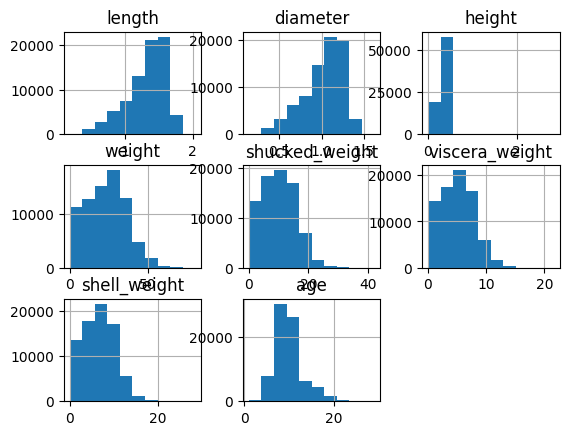

In [6]:
df_dups_removed.select_dtypes('number').hist()

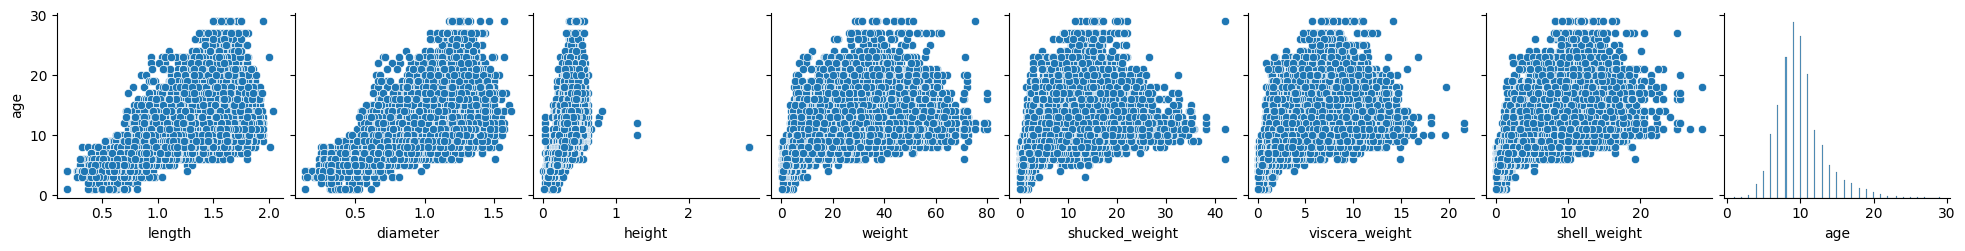

In [7]:
sns.pairplot(df_dups_removed.select_dtypes('number'), y_vars=['age'])

<Axes: >

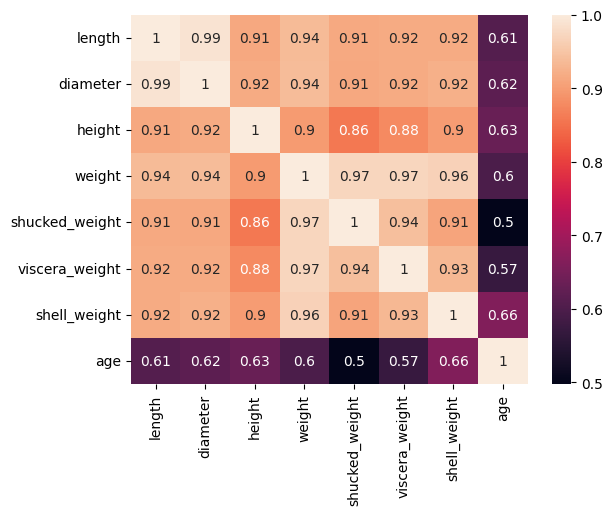

In [8]:
corr = df_dups_removed.select_dtypes('number').corr()

sns.heatmap(corr, annot=True)

In [9]:
df_dups_removed.select_dtypes('number').skew()

length           -0.833546
diameter         -0.801989
height            0.340263
weight            0.250382
shucked_weight    0.374581
viscera_weight    0.306700
shell_weight      0.299849
age               1.094883
dtype: float64

In [22]:
def replace_outliers(series: pd.Series) -> pd.Series:
    values = series.copy()
    _25, _75 = values.quantile([0.25, 0.75])
    IQR = _75 - _25
    median = values.median()
    low = median - IQR
    high = median + IQR
    count = len(values[values < low]) + len(values[values > high])
    values[values < low] = low
    values[values > high] = high
    return values, count

outliers_columns = ['height', 'weight','shucked_weight', 'shell_weight', 'viscera_weight']

clean_df = df_dups_removed.copy()

for column in outliers_columns:
    values, count = replace_outliers(clean_df[column])
    print(f"{column} outlier Count: {count}")
    clean_df[column] = values
    # print(f"{column} outlier Count: {count}")

height outlier Count: 12560
weight outlier Count: 10626
shucked_weight outlier Count: 9743
shell_weight outlier Count: 12237
viscera_weight outlier Count: 9544


In [11]:
clean_df.select_dtypes('number').skew()

length           -0.833546
diameter         -0.801989
height           -0.074835
weight           -0.001268
shucked_weight   -0.000821
viscera_weight   -0.008510
shell_weight      0.003017
age               1.094883
dtype: float64

In [14]:
# Add new features
clean_df['shell_percent'] = clean_df['shell_weight'] / clean_df['weight']
clean_df['shucked_percent'] = clean_df['shucked_weight'] / clean_df['weight']
clean_df['viscera_percent'] = clean_df['viscera_weight'] / clean_df['weight']

array([[<Axes: title={'center': 'length'}>,
        <Axes: title={'center': 'diameter'}>,
        <Axes: title={'center': 'height'}>],
       [<Axes: title={'center': 'weight'}>,
        <Axes: title={'center': 'shucked_weight'}>,
        <Axes: title={'center': 'viscera_weight'}>],
       [<Axes: title={'center': 'shell_weight'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'shell_percent'}>],
       [<Axes: title={'center': 'shucked_percent'}>,
        <Axes: title={'center': 'viscera_percent'}>, <Axes: >]],
      dtype=object)

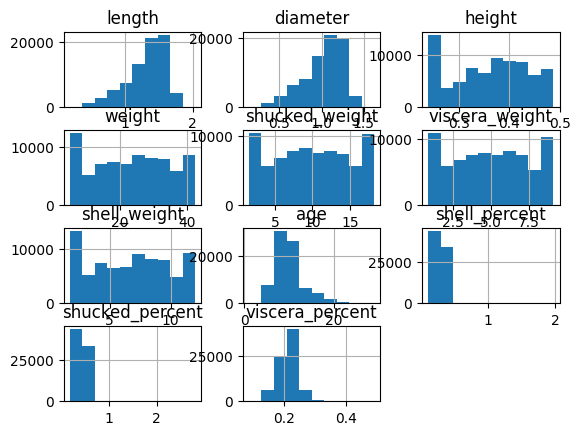

In [16]:
clean_df.select_dtypes('number').hist()

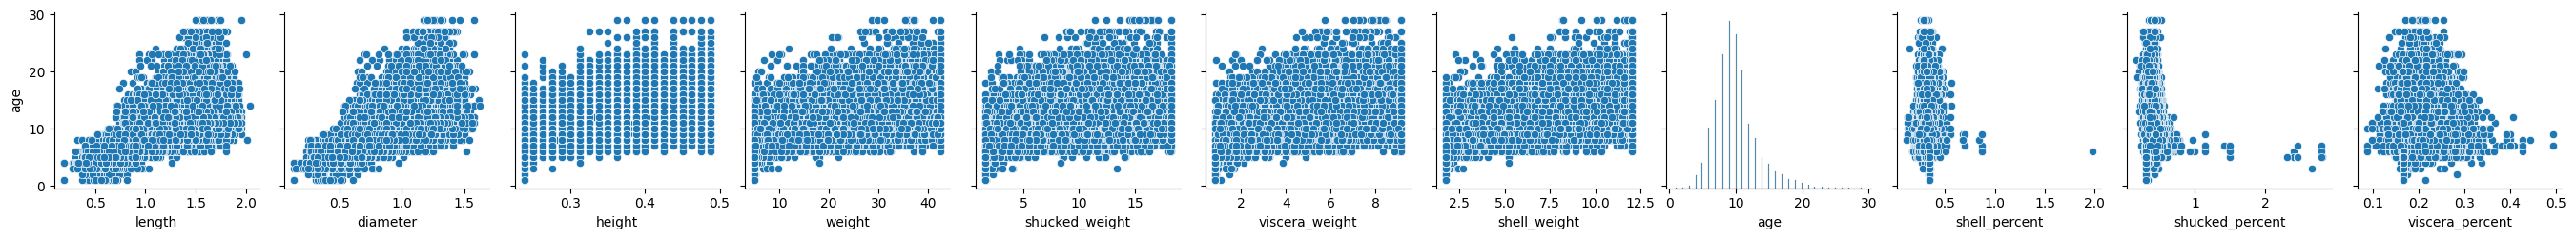

In [15]:
sns.pairplot(clean_df, y_vars=['age'])